In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nibabel as nb
from scipy import ndimage
import scipy.stats as ss
from joblib import Parallel, delayed
import sktree
from sktree import ObliqueRandomForestClassifier


In [17]:
from treeple.treeple.ensemble._supervised_forest import ObliqueRandomForestClassifier

No module named 'treeple.treeple._lib.sklearn.__check_build._check_build'
___________________________________________________________________________
Contents of c:\Users\clark\OneDrive\Documents\GitHub\bdd\treeple\treeple\_lib\sklearn\__check_build:
meson.build               _check_build.pyx          __init__.py
__pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it. For detailed instructions, see:
https://scikit-learn.org/dev/developers/advanced_installation.html#building-from-source

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.


Exception: No module named 'treeple.treeple._lib.sklearn.__check_build._check_build'
___________________________________________________________________________
Contents of c:\Users\clark\OneDrive\Documents\GitHub\bdd\treeple\treeple\_lib\sklearn\__check_build:
meson.build               _check_build.pyx          __init__.py
__pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it. For detailed instructions, see:
https://scikit-learn.org/dev/developers/advanced_installation.html#building-from-source

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

## Human Data Analysis

### Label Distribution vis

In [2]:
df = pd.read_excel('data\subjects_age_sex_data_MRI.xlsx')
df.head()

,ID,Age,Sex,Dataset,Dataset-ID
0,sub-ABIDE1050339,18.0000,MALE,ABIDE,50339
1,sub-ABIDE1050701,18.0000,MALE,ABIDE,50701
2,sub-ABIDE1050445,18.1383,MALE,ABIDE,50445
3,sub-ABIDE1050459,18.1547,MALE,ABIDE,50459
4,sub-ABIDE1050341,18.2000,FEMALE,ABIDE,50341


Text(0, 0.5, 'Age')

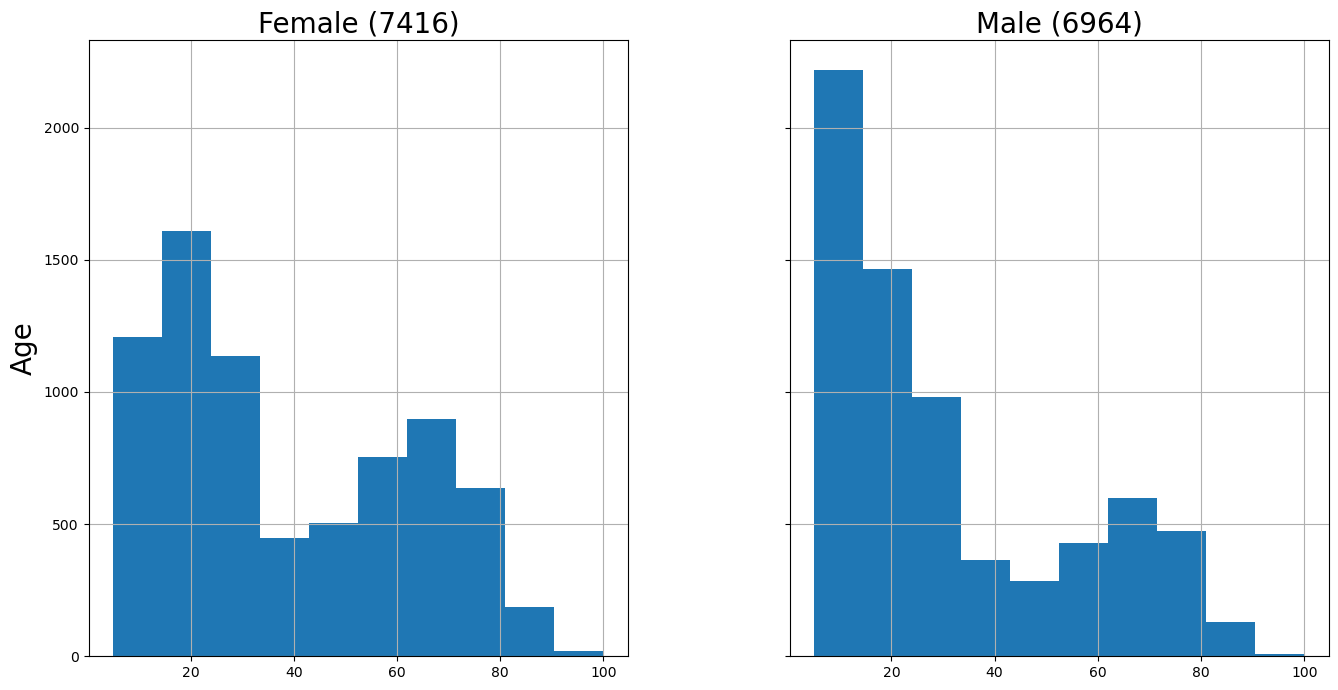

In [3]:
fig, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)

total_female = len(df[df['Sex']=='FEMALE'])
total_male = len(df[df['Sex']=='MALE'])

df[df['Sex']=='FEMALE'].hist(ax=ax[0])
df[df['Sex']=='MALE'].hist(ax=ax[1])

ax[0].set_title('Female ('+str(total_female)+')', fontsize=20)
ax[1].set_title('Male ('+str(total_male)+')', fontsize=20)

ax[0].set_ylabel('Age', fontsize=20)

### Feature Normalization

In [4]:
df_human = pd.read_excel('data/Human.parcellated_thickness.xlsx')
df_human.head()

,Unnamed: 0,sid,Markov.1,Markov.2,Markov.3,Markov.4,Markov.5,Markov.6,Markov.7,Markov.8,...,Schaefer217.191,Schaefer217.192,Schaefer217.193,Schaefer217.194,Schaefer217.195,Schaefer217.196,Schaefer217.197,Schaefer217.198,Schaefer217.199,Schaefer217.200
0,0,sub-OAS30876MRD4592,1.995032,2.203564,1.651978,1.969754,2.603206,2.295727,2.385144,2.719692,...,8.193966,7.736098,7.404804,7.431338,7.541022,7.433447,7.475594,7.460332,7.476401,7.609443
1,1,sub-HBN_CBIC_NDARXC962XNK,2.557198,2.011555,2.175673,1.863080,2.473705,2.576267,2.392282,2.242582,...,6.927265,7.487809,7.098700,6.753360,6.841211,6.707229,7.189156,6.795299,6.823550,6.533783
2,2,sub-AOMIC_0770,2.246607,2.295872,1.978412,2.069700,2.213602,2.449572,2.541624,2.777280,...,8.117053,7.775745,7.608771,7.579930,7.573511,7.607256,7.883723,7.630075,7.670835,7.354955
3,3,sub-AOMIC_0344,2.219745,2.366237,2.036068,2.173696,2.508847,2.408997,2.430510,2.882698,...,7.908504,7.856069,7.756918,7.526684,7.410575,7.654072,7.952062,7.682724,7.444550,7.697996
4,4,sub-Narratives_150,2.131236,2.432549,2.066158,2.352589,2.331565,2.799966,2.490590,2.818574,...,8.229232,7.847060,7.821367,7.739102,8.001608,7.803380,7.750091,7.730715,7.858832,7.892026


In [7]:
df_human_normalize= {}
features = df_human.columns[2:]  # features are from the 2nd column to the last

# Z-score normalization
for feature in features:
    mean = df_human[feature].mean()
    std = df_human[feature].std()
    df_human_normalize[feature] = (df_human[feature] - mean) / std

# Save the Human normalized data
df_human_normalize = pd.DataFrame(df_human_normalize)
label_human = df_human.iloc[:, :2]
df_human_normalize = pd.concat([label_human, df_human_normalize], axis=1)
df_human_normalize.to_excel('Human_normalized_parcellated_thickness.xlsx', index=False)

In [8]:
df_human_normalize.head()

,Unnamed: 0,sid,Markov.1,Markov.2,Markov.3,Markov.4,Markov.5,Markov.6,Markov.7,Markov.8,...,Schaefer217.191,Schaefer217.192,Schaefer217.193,Schaefer217.194,Schaefer217.195,Schaefer217.196,Schaefer217.197,Schaefer217.198,Schaefer217.199,Schaefer217.200
0,0,sub-OAS30876MRD4592,-0.775549,-0.766189,-1.492595,-1.069430,0.409994,-0.885375,-0.692269,-0.248215,...,0.227526,-0.003846,-0.868252,-0.517133,-0.259262,-0.114604,-1.229259,-0.657517,-0.449849,-0.081471
1,1,sub-HBN_CBIC_NDARXC962XNK,1.488213,-1.714416,0.657214,-1.589493,-0.099156,0.098169,-0.659870,-2.209368,...,-3.831496,-0.811504,-2.050433,-3.187892,-2.774903,-2.489650,-2.257417,-3.013168,-2.996411,-4.065334
2,2,sub-AOMIC_0770,0.237506,-0.310331,-0.152561,-0.582172,-1.121780,-0.346012,0.018032,-0.011503,...,-0.018932,0.125121,-0.080524,0.068217,-0.142471,0.453828,0.235705,-0.056261,0.308574,-1.024003
3,3,sub-AOMIC_0344,0.129338,0.037164,0.084123,-0.075167,0.039011,-0.488263,-0.486341,0.421815,...,-0.687209,0.386403,0.491622,-0.141533,-0.728185,0.606935,0.481005,0.130231,-0.574091,0.246499
4,4,sub-Narratives_150,-0.227077,0.364645,0.207643,0.796980,-0.657996,0.882439,-0.213624,0.158235,...,0.340534,0.357098,0.740528,0.695244,1.396425,1.095236,-0.243962,0.300225,1.041893,0.965117


In [9]:
headers = df_human_normalize.columns[2:]


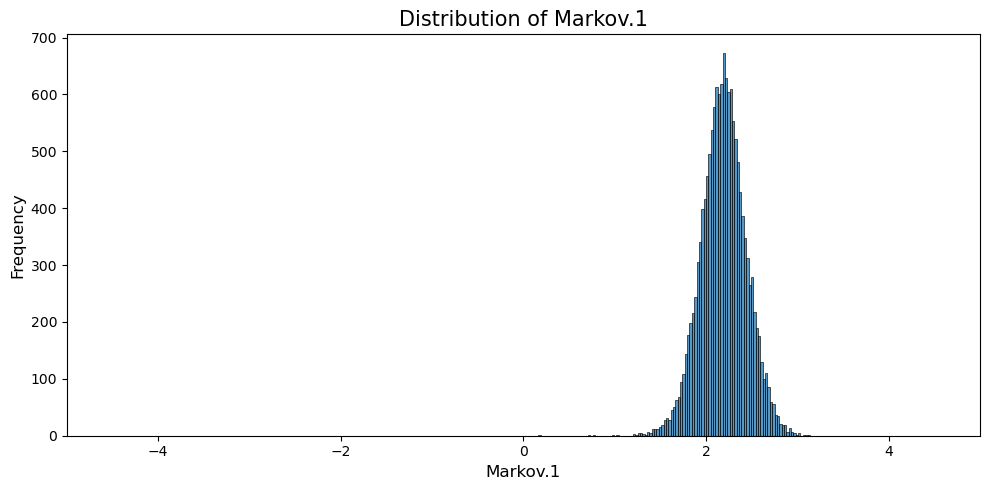

In [10]:
feature_sample = df_human.columns[2]

plt.figure(figsize=(10,5))

# histplot of the sample feature
sns.histplot(df_human[feature_sample])
plt.title(f'Distribution of {feature_sample}', fontsize=15)
plt.xlabel(feature_sample, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-5,5) 

plt.tight_layout()
plt.show()

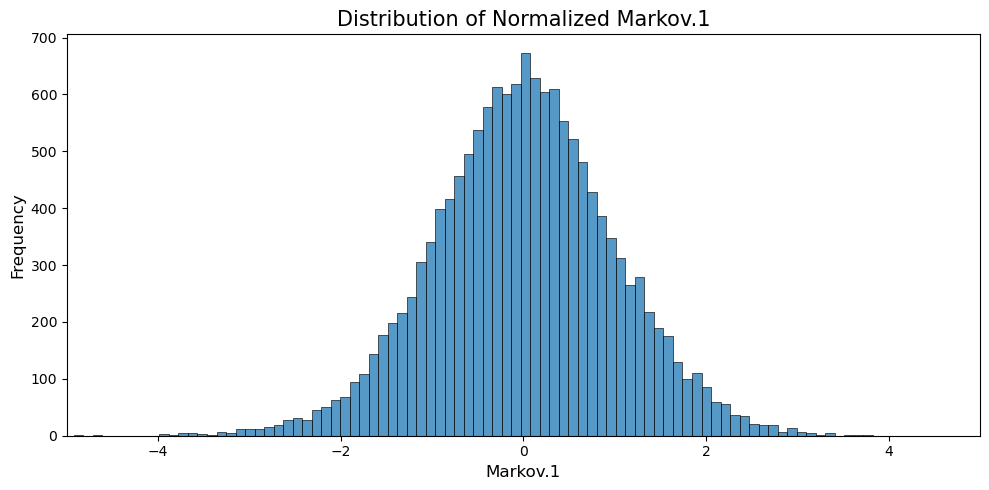

In [11]:
feature_sample = df_human_normalize.columns[2]

plt.figure(figsize=(10,5))

# histplot of the sample feature
sns.histplot(df_human_normalize[feature_sample])
plt.title(f'Distribution of Normalized {feature_sample}', fontsize=15)
plt.xlabel(feature_sample, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-5,5) 

plt.tight_layout()
plt.show()

In [12]:
df_human_normalize_markov = df_human_normalize.loc[:, ~df_human_normalize.columns.str.startswith('Schaefer')]
df_human_normalize_markov.head()

,Unnamed: 0,sid,Markov.1,Markov.2,Markov.3,Markov.4,Markov.5,Markov.6,Markov.7,Markov.8,...,Markov.173,Markov.174,Markov.175,Markov.176,Markov.177,Markov.178,Markov.179,Markov.180,Markov.181,Markov.182
0,0,sub-OAS30876MRD4592,-0.775549,-0.766189,-1.492595,-1.069430,0.409994,-0.885375,-0.692269,-0.248215,...,0.083121,-1.671051,-0.735018,-0.415062,-0.668339,-0.459439,-1.117741,-0.922454,-1.397165,-0.498600
1,1,sub-HBN_CBIC_NDARXC962XNK,1.488213,-1.714416,0.657214,-1.589493,-0.099156,0.098169,-0.659870,-2.209368,...,-2.954706,-0.765231,-1.819245,-2.806414,0.263064,-3.046151,-0.628594,0.862380,-1.933273,-1.943870
2,2,sub-AOMIC_0770,0.237506,-0.310331,-0.152561,-0.582172,-1.121780,-0.346012,0.018032,-0.011503,...,-0.218825,-0.127765,-0.299236,0.008177,-0.406170,-0.111570,-0.792261,-0.727072,-0.812408,-0.677872
3,3,sub-AOMIC_0344,0.129338,0.037164,0.084123,-0.075167,0.039011,-0.488263,-0.486341,0.421815,...,0.297458,0.190671,-0.094512,0.311386,0.168607,0.746734,0.297023,0.087743,-0.162304,-0.090668
4,4,sub-Narratives_150,-0.227077,0.364645,0.207643,0.796980,-0.657996,0.882439,-0.213624,0.158235,...,0.627643,0.881336,0.458555,0.611658,0.160755,0.571973,0.723167,0.171724,0.329283,0.393476


In [13]:
len(df_human_normalize_markov[headers[0]])


14465

In [14]:
df_sex = pd.read_excel('data/subjects_age_sex_data_MRI.xlsx')
df_sex.head()
print(len(df_sex['ID']))

14636


In [15]:
X1 = []
X2 = []
y_human = []
IDs = set(df_human_normalize_markov['sid'])
ref_IDs = set(df_sex['ID'])

for subject in tqdm(IDs):
    if subject in ref_IDs:
        features = np.array(df_human_normalize_markov[df_human_normalize_markov['sid']==subject]).reshape(-1)[2:]
        gender = list(df_sex[df_sex['ID']==subject]['Sex'])
        sex = int(gender[0]=='FEMALE')

        X1.append(list(features[:182]))
        X2.append(list(features[182:]))
        y_human.append(sex)

X1_human = np.array(X1)
X2_human = np.array(X2)

100%|██████████| 14465/14465 [00:10<00:00, 1345.71it/s]


In [16]:
print(X1_human.shape, X2_human.shape, len(y_human))

(10648, 182) (10648, 0) 10648


In [17]:
X1_human = np.nan_to_num(X1_human)
X2_human = np.nan_to_num(X2_human)
X_human = np.concatenate((X1_human,X2_human),axis=1)


In [20]:
### RF ###
reps = 5
rf_mean_accuracy = 0.0
n_estimators = [1000, 2000, 4000, 10000, 25000]
rf_accuracy = []

for ii in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
    clf = RandomForestClassifier(n_estimators=n_estimators[ii], n_jobs=-1)
    clf.fit(x_train, y_train)
    accuracy = np.mean(clf.predict(x_test)==y_test)
    rf_accuracy.append(accuracy)
    rf_mean_accuracy += np.mean(clf.predict(x_test)==y_test)

rf_mean_accuracy = rf_mean_accuracy/reps
print('Accuracy is ',accuracy)
print(rf_accuracy)

100%|██████████| 5/5 [04:44<00:00, 56.99s/it]

Accuracy is  0.7018779342723005
[np.float64(0.7061032863849765), np.float64(0.7164319248826291), np.float64(0.7), np.float64(0.7028169014084507), np.float64(0.7018779342723005)]


In [29]:
a = [1,2,3,4,5]
b = [2,3,4,5,6]
c = np.concatenate((a,b))
d = np.concatenate((c,a))
d

array([1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5])

### baby test

In [37]:
### RF ###
reps = 5
rf_mean_accuracy = 0.0
#n_estimators = [1000, 2000, 10000, 25000, 50000]
n_estimators = [100, 200, 400, 1000, 2000]
rf_accuracy = []

for n_estimator in n_estimators:
    accuracies = []
    for ii in tqdm(range(reps)):
        x_train, x_test, y_train, y_test = train_test_split(
                        X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        clf = RandomForestClassifier(n_estimators=n_estimator, n_jobs=-1)
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test)==y_test)
        accuracies.append(accuracy)
    rf_accuracy = np.concatenate((rf_accuracy, accuracies))
    print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

rf_accuracy = rf_accuracy.reshape(5, 5)
print(rf_accuracy)

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Accuracy for n_estimator =  100  is  [0.715962441314554, 0.6830985915492958, 0.6854460093896714, 0.6887323943661972, 0.6906103286384977]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Accuracy for n_estimator =  200  is  [0.7183098591549296, 0.7046948356807512, 0.6821596244131456, 0.6953051643192488, 0.7014084507042253]


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


Accuracy for n_estimator =  400  is  [0.723943661971831, 0.7046948356807512, 0.6906103286384977, 0.7004694835680751, 0.7136150234741784]


100%|██████████| 5/5 [00:42<00:00,  8.60s/it]


Accuracy for n_estimator =  1000  is  [0.7328638497652582, 0.7131455399061033, 0.6906103286384977, 0.6995305164319249, 0.7136150234741784]


100%|██████████| 5/5 [01:25<00:00, 17.11s/it]

Accuracy for n_estimator =  2000  is  [0.7234741784037558, 0.7084507042253522, 0.6924882629107981, 0.6938967136150235, 0.7131455399061033]
[[0.71596244 0.68309859 0.68544601 0.68873239 0.69061033]
 [0.71830986 0.70469484 0.68215962 0.69530516 0.70140845]
 [0.72394366 0.70469484 0.69061033 0.70046948 0.71361502]
 [0.73286385 0.71314554 0.69061033 0.69953052 0.71361502]
 [0.72347418 0.7084507  0.69248826 0.69389671 0.71314554]]


In [38]:
### SPORF ###
reps = 5

#n_estimators = [1000, 2000, 4000, 10000, 20000]
#n_estimators = [10,20,30,40,50]
sporf_accuracy = []

for n_estimator in n_estimators:
    accuracies = []
    for ii in tqdm(range(reps)):
        x_train, x_test, y_train, y_test = train_test_split(
                        X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        clf = ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, feature_combinations=2.3)
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test)==y_test)
        accuracies.append(accuracy)
    sporf_accuracy = np.concatenate((sporf_accuracy, accuracies))
    print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

sporf_accuracy = sporf_accuracy.reshape(5, 5)
print(sporf_accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Accuracy for n_estimator =  100  is  [0.6901408450704225, 0.6896713615023474, 0.6708920187793427, 0.6953051643192488, 0.7018779342723005]


  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Accuracy for n_estimator =  200  is  [0.7145539906103286, 0.6938967136150235, 0.6953051643192488, 0.6976525821596244, 0.6995305164319249]


  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Accuracy for n_estimator =  400  is  [0.7211267605633803, 0.712206572769953, 0.6924882629107981, 0.7056338028169014, 0.712206572769953]


  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Accuracy for n_estimator =  1000  is  [0.72018779342723, 0.7046948356807512, 0.7018779342723005, 0.7107981220657277, 0.7145539906103286]


  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Accuracy for n_estimator =  2000  is  [0.7234741784037558, 0.7112676056338029, 0.6962441314553991, 0.7009389671361502, 0.7084507042253522]
[[0.69014085 0.68967136 0.67089202 0.69530516 0.70187793]
 [0.71455399 0.69389671 0.69530516 0.69765258 0.69953052]
 [0.72112676 0.71220657 0.69248826 0.7056338  0.71220657]
 [0.72018779 0.70469484 0.70187793 0.71079812 0.71455399]
 [0.72347418 0.71126761 0.69624413 0.70093897 0.7084507 ]]


In [39]:
# Save rf_accuracy and sporf_accuracy to txt files
np.savetxt('rf_accuracy.txt', rf_accuracy)
np.savetxt('sporf_accuracy.txt', sporf_accuracy)



In [40]:
# Read rf_accuracy and sporf_accuracy from txt files
rf_accuracy_loaded = np.loadtxt('rf_accuracy.txt')
sporf_accuracy_loaded = np.loadtxt('sporf_accuracy.txt')

print(rf_accuracy_loaded)
print(sporf_accuracy_loaded)

[[0.71596244 0.68309859 0.68544601 0.68873239 0.69061033]
 [0.71830986 0.70469484 0.68215962 0.69530516 0.70140845]
 [0.72394366 0.70469484 0.69061033 0.70046948 0.71361502]
 [0.73286385 0.71314554 0.69061033 0.69953052 0.71361502]
 [0.72347418 0.7084507  0.69248826 0.69389671 0.71314554]]
[[0.69014085 0.68967136 0.67089202 0.69530516 0.70187793]
 [0.71455399 0.69389671 0.69530516 0.69765258 0.69953052]
 [0.72112676 0.71220657 0.69248826 0.7056338  0.71220657]
 [0.72018779 0.70469484 0.70187793 0.71079812 0.71455399]
 [0.72347418 0.71126761 0.69624413 0.70093897 0.7084507 ]]


In [41]:
rf_accuracy_loaded[1]

array([0.71830986, 0.70469484, 0.68215962, 0.69530516, 0.70140845])

### real test

In [35]:
### RF ###
reps = 5
rf_mean_accuracy = 0.0
#n_estimators = [1000, 2000, 10000, 25000, 50000]
n_estimators = [1000, 2000, 4000, 10000, 20000]
rf_accuracy = []

for n_estimator in n_estimators:
    accuracies = []
    for ii in tqdm(range(reps)):
        x_train, x_test, y_train, y_test = train_test_split(
                        X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        clf = RandomForestClassifier(n_estimators=n_estimator, n_jobs=-1)
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test)==y_test)
        accuracies.append(accuracy)
    rf_accuracy = np.concatenate((rf_accuracy, accuracies))
    print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

print(rf_accuracy)

100%|██████████| 5/5 [00:45<00:00,  9.13s/it]


Accuracy for n_estimator =  1000  is  [0.7258215962441315, 0.7093896713615023, 0.6976525821596244, 0.7070422535211267, 0.7107981220657277]


100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


Accuracy for n_estimator =  2000  is  [0.7276995305164319, 0.7131455399061033, 0.692018779342723, 0.6990610328638498, 0.72018779342723]


100%|██████████| 5/5 [02:54<00:00, 34.95s/it]


Accuracy for n_estimator =  4000  is  [0.7253521126760564, 0.7140845070422536, 0.6924882629107981, 0.7051643192488263, 0.7187793427230047]


 60%|██████    | 3/5 [04:33<03:02, 91.18s/it]


KeyboardInterrupt: 

In [ ]:
rf_accuracy = rf_accuracy.reshape(5, 5)
print(rf_accuracy)

[[0.62910798 0.62300469 0.60892019 0.60985915 0.63098592]
 [0.64835681 0.64460094 0.64507042 0.65680751 0.65821596]
 [0.67042254 0.65117371 0.64882629 0.65821596 0.67089202]
 [0.6657277  0.68779343 0.66525822 0.66197183 0.66995305]
 [0.68403756 0.68638498 0.6713615  0.66525822 0.67793427]]


In [ ]:
### SPORF ###
reps = 5

n_estimators = [1000, 2000, 4000, 10000, 20000]
#n_estimators = [10,20,30,40,50]
sporf_accuracy = []

for n_estimator in n_estimators:
    accuracies = []
    for ii in tqdm(range(reps)):
        x_train, x_test, y_train, y_test = train_test_split(
                        X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        clf = ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, feature_combinations=2.3)
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test)==y_test)
        accuracies.append(accuracy)
    sporf_accuracy = np.concatenate((sporf_accuracy, accuracies))
    print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

print(sporf_accuracy)

In [ ]:
sporf_accuracy = sporf_accuracy.reshape(5, 5)
print(sporf_accuracy)

In [20]:
### SPORF ###
reps = 5
accuracy = 0.0

for ii in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
    clf = ObliqueRandomForestClassifier(n_estimators=1000, n_jobs=-1, feature_combinations=2.3)
    clf.fit(x_train,y_train)
    accuracy += np.mean(clf.predict(x_test)==y_test)

print('Accuracy is ',accuracy/reps)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Accuracy is  0.7107981220657277


In [2]:
from numba import jit, cuda 
import numpy as np 
# to measure exec time 
from timeit import default_timer as timer 

In [4]:


# normal function to run on cpu 
def func(a):								 
	for i in range(10000000): 
		a[i]+= 1	

# function optimized to run on gpu 
@jit(target_backend='cuda')						 
def func2(a): 
	for i in range(10000000): 
		a[i]+= 1



In [5]:

n = 10000000							
a = np.ones(n, dtype = np.float64) 

start = timer() 
func(a) 
print("without GPU:", timer()-start)	 

start = timer() 
func2(a) 
print("with GPU:", timer()-start) 

without GPU: 0.8446168999998918


KeyError: "Unrecognized options: {'target_backend'}. Known options are dict_keys(['_dbg_extend_lifetimes', '_dbg_optnone', '_nrt', 'boundscheck', 'debug', 'error_model', 'fastmath', 'forceinline', 'forceobj', 'inline', 'looplift', 'no_cfunc_wrapper', 'no_cpython_wrapper', 'no_rewrites', 'nogil', 'nopython', 'parallel'])"

## Hyperparameter tuning

In [18]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [38]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Fixed hyperparameter
N_ESTIMATORS = 1000  # Fixing n_estimators to 1000

# Define the search space (excluding n_estimators)
space = [
    Real(0.1, 1.0, name='max_features'),
    Real(1.0, 5.0, name='feature_combinations')
]

# Objective function to minimize
@use_named_args(space)
def objective(max_features, feature_combinations):
    reps = 5
    accuracies = []
    for ii in range(reps):
        x_train, x_test, y_train, y_test = train_test_split(
            X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        
        clf = ObliqueRandomForestClassifier(
            n_estimators=N_ESTIMATORS,  # Fixed value
            max_features=max_features, 
            feature_combinations=feature_combinations,
            n_jobs=-1
        )
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test) == y_test)
        accuracies.append(accuracy)
    
    mean_accuracy = np.mean(accuracies)
    return -mean_accuracy  # Bayesian optimization minimizes, so negate accuracy

# Number of optimization iterations
N_CALLS = 20  

# Run Bayesian Optimization with a progress bar
with tqdm(total=N_CALLS, desc="Optimizing Hyperparameters") as pbar:
    def callback(res):
        pbar.update(1)  # Update progress bar on each iteration
    
    res = gp_minimize(objective, space, n_calls=N_CALLS, random_state=42, callback=[callback])

# Best hyperparameters
best_hyperparams = {
    "n_estimators": N_ESTIMATORS,  # Fixed
    "max_features": res.x[0],
    "feature_combinations": res.x[1]
}

print("Best hyperparameters:", best_hyperparams)


Optimizing Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: Fut

Best hyperparameters: {'n_estimators': 1000, 'max_features': 0.9973623034122729, 'feature_combinations': 4.989230502925718}


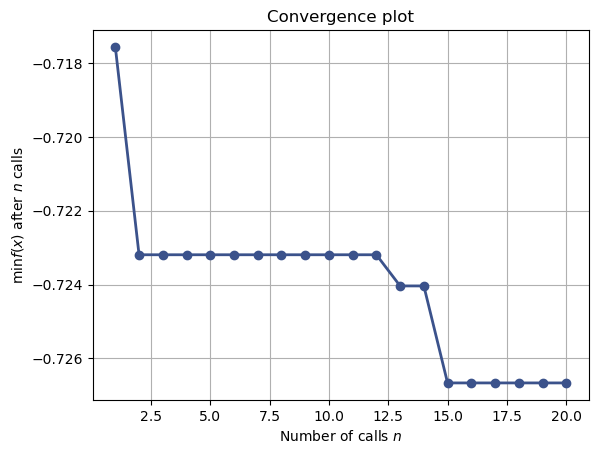

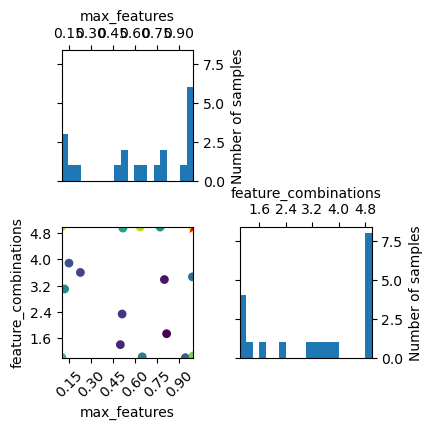

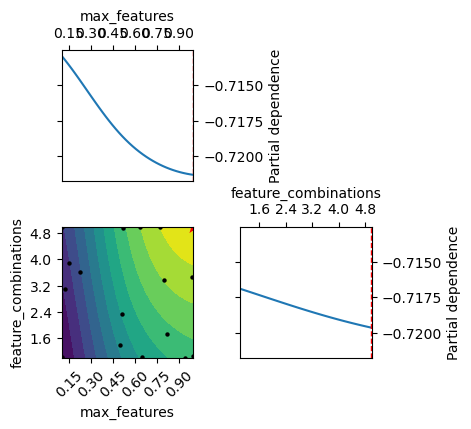

In [39]:
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

# 1️⃣ Convergence plot: Tracks best score over iterations
plot_convergence(res)
plt.show()

# 2️⃣ Objective function evaluations: Shows which parameter settings were tested
plot_evaluations(res)
plt.show()

# 3️⃣ Partial dependence plot: Effect of each hyperparameter on objective function
plot_objective(res)
plt.show()


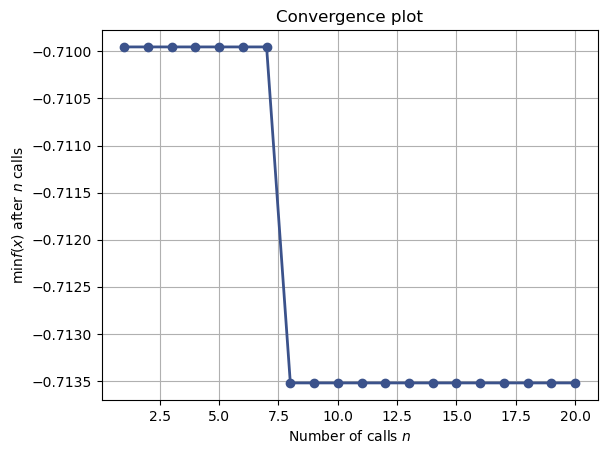

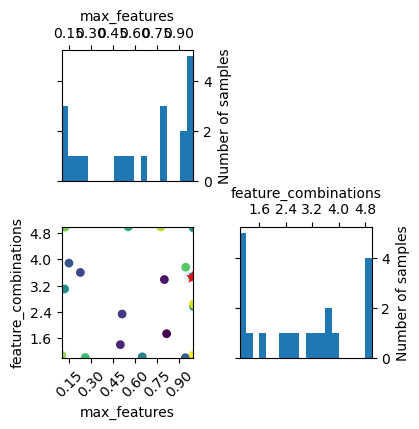

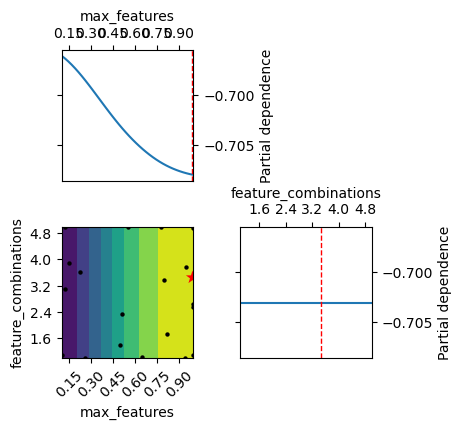

In [41]:
# 1️⃣ Convergence plot: Tracks best score over iterations
plot_convergence(res)
plt.show()

# 2️⃣ Objective function evaluations: Shows which parameter settings were tested
plot_evaluations(res)
plt.show()

# 3️⃣ Partial dependence plot: Effect of each hyperparameter on objective function
plot_objective(res)
plt.show()

In [40]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Fixed hyperparameter
N_ESTIMATORS = 100  # Fixing n_estimators to 1000

# Define the search space (excluding n_estimators)
space = [
    Real(0.1, 1.0, name='max_features'),
    Real(1.0, 5.0, name='feature_combinations')
]

# Objective function to minimize
@use_named_args(space)
def objective(max_features, feature_combinations):
    reps = 5
    accuracies = []
    for ii in range(reps):
        x_train, x_test, y_train, y_test = train_test_split(
            X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        
        clf = ObliqueRandomForestClassifier(
            n_estimators=N_ESTIMATORS,  # Fixed value
            max_features=max_features, 
            feature_combinations=feature_combinations,
            n_jobs=-1
        )
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test) == y_test)
        accuracies.append(accuracy)
    
    mean_accuracy = np.mean(accuracies)
    return -mean_accuracy  # Bayesian optimization minimizes, so negate accuracy

# Number of optimization iterations
N_CALLS = 20  

# Run Bayesian Optimization with a progress bar
with tqdm(total=N_CALLS, desc="Optimizing Hyperparameters") as pbar:
    def callback(res):
        pbar.update(1)  # Update progress bar on each iteration
    
    res = gp_minimize(objective, space, n_calls=N_CALLS, random_state=42, callback=[callback])

# Best hyperparameters
best_hyperparams = {
    "n_estimators": N_ESTIMATORS,  # Fixed
    "max_features": res.x[0],
    "feature_combinations": res.x[1]
}

print("Best hyperparameters:", best_hyperparams)

Optimizing Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: Fut

Best hyperparameters: {'n_estimators': 100, 'max_features': 0.992990403362096, 'feature_combinations': 3.4699260385108666}


Test sporf accuracy with estimated hyperparameter
1. max_features=0.993, feature_combinations=3.470
Obtained from tuning that uses n_estimator=100

In [42]:
### SPORF ###
reps = 5

#n_estimators = [1000, 2000, 4000, 10000, 20000]
n_estimators = [100,200,400,1000,2000]
sporf_accuracy1 = []

for n_estimator in n_estimators:
    accuracies = []
    for ii in tqdm(range(reps)):
        x_train, x_test, y_train, y_test = train_test_split(
                        X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        clf = ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, max_features=0.993, feature_combinations=3.470)
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test)==y_test)
        accuracies.append(accuracy)
    sporf_accuracy1 = np.concatenate((sporf_accuracy1, accuracies))
    print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

sporf_accuracy1 = sporf_accuracy1.reshape(5, 5)
print(sporf_accuracy1)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  100  is  [np.float64(0.7136150234741784), np.float64(0.7004694835680751), np.float64(0.7248826291079812), np.float64(0.707981220657277), np.float64(0.7018779342723005)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  200  is  [np.float64(0.719718309859155), np.float64(0.7023474178403756), np.float64(0.7286384976525822), np.float64(0.7051643192488263), np.float64(0.7023474178403756)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  400  is  [np.float64(0.723943661971831), np.float64(0.7004694835680751), np.float64(0.7370892018779343), np.float64(0.715962441314554), np.float64(0.7173708920187793)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  1000  is  [np.float64(0.7338028169014085), np.float64(0.7112676056338029), np.float64(0.7460093896713615), np.float64(0.7103286384976526), np.float64(0.715962441314554)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  2000  is  [np.float64(0.7291079812206572), np.float64(0.7093896713615023), np.float64(0.7436619718309859), np.float64(0.719718309859155), np.float64(0.7150234741784037)]
[[0.71361502 0.70046948 0.72488263 0.70798122 0.70187793]
 [0.71971831 0.70234742 0.7286385  0.70516432 0.70234742]
 [0.72394366 0.70046948 0.7370892  0.71596244 0.71737089]
 [0.73380282 0.71126761 0.74600939 0.71032864 0.71596244]
 [0.72910798 0.70938967 0.74366197 0.71971831 0.71502347]]


In [43]:
# Save rf_accuracy and sporf_accuracy to txt files
np.savetxt('sporf_accuracy1.txt', sporf_accuracy1)


2. max_feature=0.997, feature_combinations=4.989
Obtained from tuning that uses n_estimator=1000

In [46]:
### SPORF ###
reps = 5

#n_estimators = [1000, 2000, 4000, 10000, 20000]
#n_estimators = [10,20,30,40,50]
sporf_accuracy2 = []

for n_estimator in n_estimators:
    accuracies = []
    for ii in tqdm(range(reps)):
        x_train, x_test, y_train, y_test = train_test_split(
                        X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
        clf = ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, max_features=0.997, feature_combinations=4.989)
        clf.fit(x_train, y_train)
        accuracy = np.mean(clf.predict(x_test)==y_test)
        accuracies.append(accuracy)
    sporf_accuracy2 = np.concatenate((sporf_accuracy2, accuracies))
    print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

sporf_accuracy2 = sporf_accuracy2.reshape(5, 5)
print(sporf_accuracy2)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  100  is  [np.float64(0.7112676056338029), np.float64(0.6948356807511737), np.float64(0.7131455399061033), np.float64(0.7051643192488263), np.float64(0.7051643192488263)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  200  is  [np.float64(0.7211267605633803), np.float64(0.7051643192488263), np.float64(0.7347417840375586), np.float64(0.712206572769953), np.float64(0.7140845070422536)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  400  is  [np.float64(0.7225352112676057), np.float64(0.7103286384976526), np.float64(0.7464788732394366), np.float64(0.7258215962441315), np.float64(0.711737089201878)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  1000  is  [np.float64(0.7262910798122065), np.float64(0.7103286384976526), np.float64(0.7497652582159624), np.float64(0.7234741784037558), np.float64(0.7145539906103286)]


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\clark\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite

Accuracy for n_estimator =  2000  is  [np.float64(0.7300469483568075), np.float64(0.7089201877934272), np.float64(0.7413145539906103), np.float64(0.7258215962441315), np.float64(0.7169014084507043)]
[[0.71126761 0.69483568 0.71314554 0.70516432 0.70516432]
 [0.72112676 0.70516432 0.73474178 0.71220657 0.71408451]
 [0.72253521 0.71032864 0.74647887 0.7258216  0.71173709]
 [0.72629108 0.71032864 0.74976526 0.72347418 0.71455399]
 [0.73004695 0.70892019 0.74131455 0.7258216  0.71690141]]


In [47]:
# Save rf_accuracy and sporf_accuracy to txt files
np.savetxt('sporf_accuracy2.txt', sporf_accuracy2)


## Macaque Data Analysis

In [13]:
df = pd.read_csv('data/uwmadison.csv')
df.head()

,participant_id,age,sex
0,sub-1001,1.756164,M
1,sub-1002,1.783562,F
2,sub-1003,1.756164,M
3,sub-1004,1.756164,M
4,sub-1005,1.742466,M


Text(0, 0.5, 'Age')

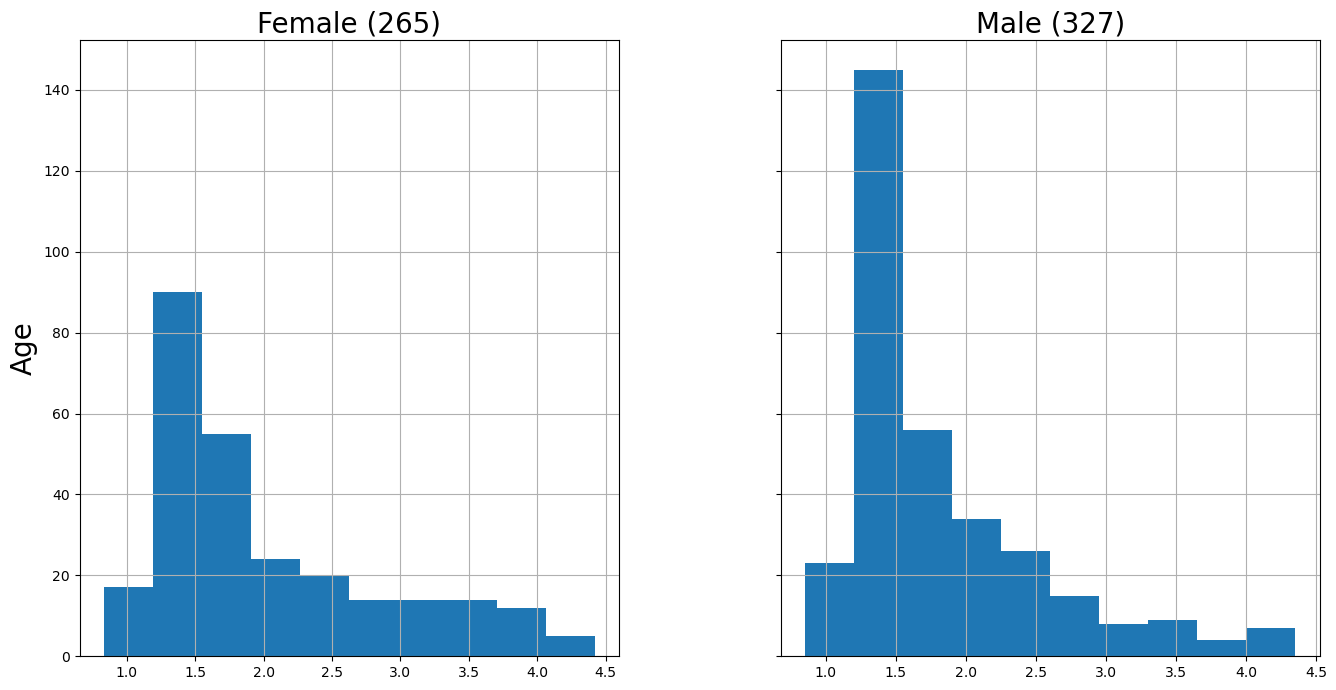

In [14]:
fig, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)

total_female = len(df[df['sex']=='F'])
total_male = len(df[df['sex']=='M'])

df[df['sex']=='F'].hist(ax=ax[0])
df[df['sex']=='M'].hist(ax=ax[1])

ax[0].set_title('Female ('+str(total_female)+')', fontsize=20)
ax[1].set_title('Male ('+str(total_male)+')', fontsize=20)

ax[0].set_ylabel('Age', fontsize=20)

In [16]:
df_macaque = pd.read_excel('data/Macaque.parcellated_thickness.xlsx')
df_macaque.head()

,Unnamed: 0,participant_id,age,sex,Markov.1,Markov.2,Markov.3,Markov.4,Markov.5,Markov.6,...,Schaefer217.191,Schaefer217.192,Schaefer217.193,Schaefer217.194,Schaefer217.195,Schaefer217.196,Schaefer217.197,Schaefer217.198,Schaefer217.199,Schaefer217.200
0,0,sub-1001,1.756164,M,3.048436,3.908286,3.221595,3.615675,4.662432,3.707754,...,4.231826,4.908868,4.522730,2.294943,2.853976,3.406234,4.261370,4.131977,3.387978,3.451267
1,1,sub-1002,1.783562,F,3.053520,3.748308,3.043567,3.764927,4.708283,4.060617,...,4.384853,4.849508,4.589500,2.443734,2.855187,3.344378,3.926697,3.477919,2.962553,3.474969
2,2,sub-1003,1.756164,M,3.211265,4.122524,3.374628,4.022762,4.759439,4.182558,...,4.570739,4.921833,4.770724,3.106145,3.094785,3.350355,4.562199,4.212585,3.582792,3.827813
3,3,sub-1004,1.756164,M,3.004275,3.681716,3.227427,3.762712,4.555942,3.984013,...,4.264869,4.935628,4.505048,3.337418,2.892611,3.690076,4.095378,4.328465,3.763171,3.758017
4,4,sub-1005,1.742466,M,2.868796,3.837011,2.997172,3.724171,4.537298,3.816082,...,4.154663,4.817727,4.695378,3.965287,3.219764,3.268439,4.115168,3.889531,3.271547,4.040183


In [17]:
df_macaque_normalize= {}
features = df_macaque.columns[4:]  # features are from the 2nd column to the last

# Z-score normalization
for feature in features:
    mean = df_macaque[feature].mean()
    std = df_macaque[feature].std()
    df_macaque_normalize[feature] = (df_macaque[feature] - mean) / std

# Save the Human normalized data
df_macaque_normalize = pd.DataFrame(df_macaque_normalize)
label_macaque = df_macaque.iloc[:, :4]
df_macaque_normalize = pd.concat([label_macaque, df_macaque_normalize], axis=1)
df_macaque_normalize.to_excel('Macaque_normalized_parcellated_thickness.xlsx', index=False)

In [18]:
df_macaque_normalize.head()

,Unnamed: 0,participant_id,age,sex,Markov.1,Markov.2,Markov.3,Markov.4,Markov.5,Markov.6,...,Schaefer217.191,Schaefer217.192,Schaefer217.193,Schaefer217.194,Schaefer217.195,Schaefer217.196,Schaefer217.197,Schaefer217.198,Schaefer217.199,Schaefer217.200
0,0,sub-1001,1.756164,M,0.022776,0.186669,0.517615,-0.693460,0.647652,0.009852,...,-0.476449,0.964997,0.573463,-1.139774,-0.886799,0.550320,0.692718,0.850013,0.334241,-0.337606
1,1,sub-1002,1.783562,F,0.045095,-0.611675,-0.704012,0.045374,0.841457,1.283684,...,0.766879,0.207089,1.031874,-0.760713,-0.882121,0.314296,-1.065794,-1.679927,-1.244096,-0.244224
2,2,sub-1003,1.756164,M,0.737540,1.255789,1.567724,1.321717,1.057688,1.723890,...,2.277182,1.130530,2.276062,0.926858,0.042886,0.337102,2.273404,1.161811,1.057004,1.145977
3,3,sub-1004,1.756164,M,-0.171071,-0.943997,0.557631,0.034409,0.197532,1.007145,...,-0.207979,1.306663,0.452062,1.516053,-0.737640,1.633377,-0.179469,1.610042,1.726218,0.870983
4,4,sub-1005,1.742466,M,-0.765778,-0.169020,-1.022376,-0.156378,0.118726,0.400915,...,-1.103385,-0.198697,1.758774,3.115625,0.525387,0.024538,-0.075489,-0.087785,-0.097722,1.982710


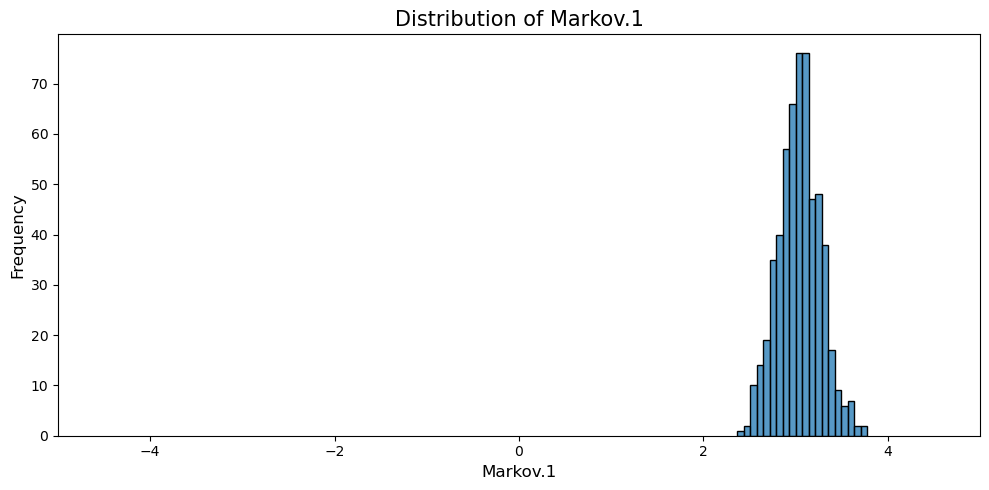

In [19]:
feature_sample = df_macaque.columns[4]

plt.figure(figsize=(10,5))

# histplot of the sample feature
sns.histplot(df_macaque[feature_sample])
plt.title(f'Distribution of {feature_sample}', fontsize=15)
plt.xlabel(feature_sample, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-5,5) 

plt.tight_layout()
plt.show()

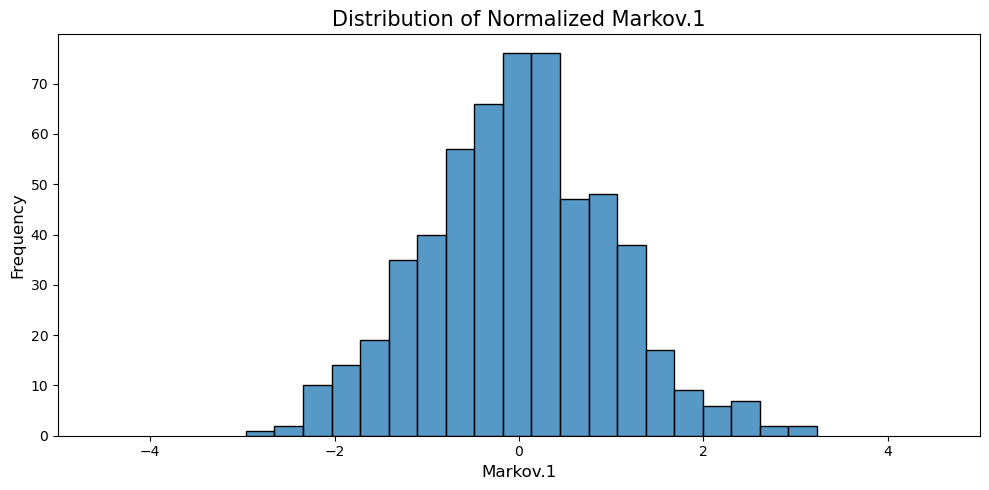

In [20]:
feature_sample = df_macaque_normalize.columns[4]

plt.figure(figsize=(10,5))

# histplot of the sample feature
sns.histplot(df_macaque_normalize[feature_sample])
plt.title(f'Distribution of Normalized {feature_sample}', fontsize=15)
plt.xlabel(feature_sample, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-5,5) 

plt.tight_layout()
plt.show()